**GPU is required to run the code**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
import shutil
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D, BatchNormalization, Input, Conv2DTranspose, Concatenate
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
import random
import h5py
from IPython.display import display
from PIL import Image as im
import datetime
import random
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


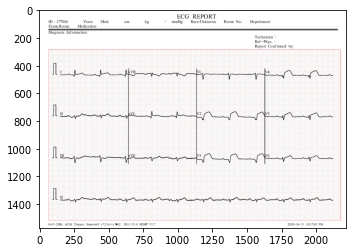

In [ ]:
 import imageio
 import matplotlib.pyplot as plt
 %matplotlib inline
 pic = imageio.imread("/content/drive/MyDrive/datsetfinal2/train/ECG Images of Myocardial Infarction Patients (240x12=2880)/MI(100).jpg")
 #plt.figure(figsize = (5,5))
 plt.imshow(pic)

In [ ]:
print('Type of the image : ' , type(pic)) 
print('Shape of the image : {}'.format(pic.shape)) 
print('Image Hight {}'.format(pic.shape[0])) 
print('Image Width {}'.format(pic.shape[1])) 
print('Dimension of Image {}'.format(pic.ndim))
print('Image size {}'.format(pic.size)) 
print('Maximum RGB value in this image {}'.format(pic.max()))
print('Minimum RGB value in this image {}'.format(pic.min()))
print('Value of only R channel {}'.format(pic[ 100, 50, 0])) 
print('Value of only G channel {}'.format(pic[ 100, 50, 1])) 
print('Value of only B channel {}'.format(pic[ 100, 50, 2]))

Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (1572, 2213, 3)
Image Hight 1572
Image Width 2213
Dimension of Image 3
Image size 10436508
Maximum RGB value in this image 255
Minimum RGB value in this image 0
Value of only R channel 255
Value of only G channel 255
Value of only B channel 255


In [ ]:
train_path="/content/drive/MyDrive/datsetfinal2/train"
test_path="/content/drive/MyDrive/datsetfinal2/test"
val_path="/content/drive/MyDrive/datsetfinal2/validation"

In [ ]:
x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(254,254))

        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(254,254))

        x_test.append(img_arr)

x_val=[]

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(254,254))

        x_val.append(img_arr)


In [ ]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [ ]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (254, 254),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (254, 254),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (254, 254),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1792 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [ ]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [ ]:
training_set.class_indices

{'ECG Images of Myocardial Infarction Patients (240x12=2880)': 0,
 'ECG Images of Patient that have History of MI (172x12=2064)': 1,
 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 2,
 'Normal Person ECG Images (284x12=3408)': 3}

In [ ]:
train_y.shape,test_y.shape,val_y.shape

((1792,), (600,), (600,))

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
#vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg = VGG19(input_shape=(254,254,3), weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 2s 0us/step


In [ ]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
x = Flatten()(vgg.output)

In [ ]:
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 254, 254, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 254, 254, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 254, 254, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0     

In [ ]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

In [ ]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
56/56 [==============================] - 36s 387ms/step - loss: 1.2596 - accuracy: 0.4939 - val_loss: 0.8939 - val_accuracy: 0.6433
Epoch 2/10
56/56 [==============================] - 18s 318ms/step - loss: 0.6545 - accuracy: 0.7567 - val_loss: 0.6594 - val_accuracy: 0.7433
Epoch 3/10
56/56 [==============================] - 18s 329ms/step - loss: 0.4539 - accuracy: 0.8588 - val_loss: 0.4772 - val_accuracy: 0.8533
Epoch 4/10
56/56 [==============================] - 18s 322ms/step - loss: 0.3841 - accuracy: 0.8979 - val_loss: 0.4830 - val_accuracy: 0.8450
Epoch 5/10
56/56 [==============================] - 18s 317ms/step - loss: 0.3598 - accuracy: 0.8912 - val_loss: 0.4083 - val_accuracy: 0.8500
Epoch 6/10
56/56 [==============================] - 18s 316ms/step - loss: 0.2756 - accuracy: 0.9280 - val_loss: 0.3182 - val_accuracy: 0.9317
Epoch 7/10
56/56 [==============================] - 18s 318ms/step - loss: 0.2329 - accuracy: 0.9408 - val_loss: 0.2354 - val_accuracy: 0.9483

In [ ]:
model.evaluate(train_x,train_y,batch_size=32)

56/56 [==============================] - 14s 236ms/step - loss: 0.1875 - accuracy: 0.9475


[0.18747268617153168, 0.9475446343421936]

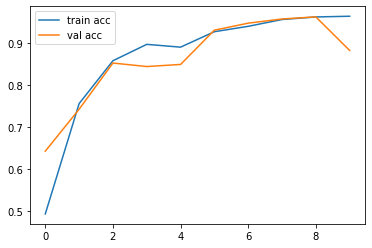

In [ ]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()

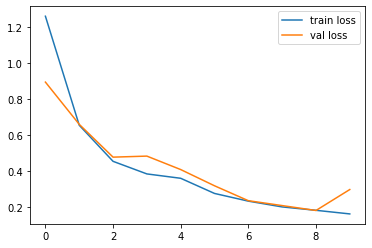

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [ ]:
# savedModel=models.load_model('teachermodel1.h5')
# savedModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 254, 254, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 254, 254, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 254, 254, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0     

**2. Student Model**

In [ ]:
# import necessary layers  
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
# input
input = Input(shape =(254,254,3))
# 1st Conv Block
x = Conv2D (filters =8, kernel_size =4, padding ='valid', activation='relu')(input)
x = Conv2D (filters =8, kernel_size =4, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 2nd Conv Block
x = Conv2D (filters =16, kernel_size =4, padding ='valid', activation='relu')(x)
x = Conv2D (filters =16, kernel_size =4, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 3rd Conv block
x = Conv2D (filters =32, kernel_size= 4, padding ='valid', activation='relu')(x)
x = Conv2D (filters =32, kernel_size =4, padding ='valid', activation='relu')(x)
#x = Conv2D (filters =32, kernel_size =4, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 4th Conv block
x = Conv2D (filters =64, kernel_size =4, padding ='valid', activation='relu')(x)
x = Conv2D (filters =64, kernel_size =4, padding ='valid', activation='relu')(x)
#x = Conv2D (filters =64, kernel_size =4, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 5th Conv block
x = Conv2D (filters =64, kernel_size =4, padding ='valid', activation='relu')(x)
x = Conv2D (filters =64, kernel_size =4, padding ='valid', activation='relu')(x)
#x = Conv2D (filters =64, kernel_size =4, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# Fully connected layers
x = Flatten()(x)
#x = Dense(units = 1028, activation ='relu')(x)
x = Dense(units = 256, activation ='relu')(x)
x = Dropout(0.5)(x)
output = Dense(units = 4)(x)   #last layer with linear activation
# creating the model
s_model_1 = Model (inputs=input, outputs =output)
s_model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 254, 254, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 251, 251, 8)       392       
                                                                 
 conv2d_1 (Conv2D)           (None, 248, 248, 8)       1032      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 16)      2064      
                                                                 
 conv2d_3 (Conv2D)           (None, 118, 118, 16)      4112      
                                                           

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation


In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=2,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
    def train_step(self, data):
        # Unpack data
        x, y = data
        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        #model = ...  # create the original model
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            # Forward pass of student
            student_predictions = self.student(x, training=True)
            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss +  distillation_loss
        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
# Initialize and compile distiller
#distiller = Distiller(student=s_model_1, teacher=model)
distiller = Distiller(student=s_model_1, teacher=model)
distiller.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001),
    metrics=['acc'],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    #distillation_loss_fn=CategoricalCrossentropy(), 
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.5,
    temperature=6,
)


In [ ]:
# Distill teacher to student
distiller_hist = distiller.fit(train_x, train_y,validation_data=(val_x,val_y),epochs=10, callbacks=[early_stop],batch_size=32,shuffle=True)

Epoch 1/10
56/56 [==============================] - ETA: 0s - acc: 0.2667 - student_loss: 1.3853 - distillation_loss: 2.6381e-04

56/56 [==============================] - 22s 305ms/step - acc: 0.2667 - student_loss: 1.3853 - distillation_loss: 2.6314e-04 - val_acc: 0.2500 - val_student_loss: 1.3488
Epoch 2/10
56/56 [==============================] - ETA: 0s - acc: 0.2768 - student_loss: 1.3818 - distillation_loss: 2.3039e-04

56/56 [==============================] - 16s 290ms/step - acc: 0.2768 - student_loss: 1.3821 - distillation_loss: 2.3013e-04 - val_acc: 0.2517 - val_student_loss: 1.2774
Epoch 3/10
56/56 [==============================] - ETA: 0s - acc: 0.2946 - student_loss: 1.3739 - distillation_loss: 3.0533e-04

56/56 [==============================] - 17s 295ms/step - acc: 0.2946 - student_loss: 1.3739 - distillation_loss: 3.0340e-04 - val_acc: 0.3350 - val_student_loss: 1.1937
Epoch 4/10
56/56 [==============================] - ETA: 0s - acc: 0.3683 - student_loss: 1.3169 - distillation_loss: 0.0015

56/56 [==============================] - 17s 299ms/step - acc: 0.3683 - student_loss: 1.3152 - distillation_loss: 0.0015 - val_acc: 0.4150 - val_student_loss: 1.4022
Epoch 5/10
56/56 [==============================] - ETA: 0s - acc: 0.4118 - student_loss: 1.2320 - distillation_loss: 0.0039

56/56 [==============================] - 17s 304ms/step - acc: 0.4118 - student_loss: 1.2293 - distillation_loss: 0.0039 - val_acc: 0.5117 - val_student_loss: 0.9299
Epoch 6/10
56/56 [==============================] - ETA: 0s - acc: 0.5279 - student_loss: 1.0896 - distillation_loss: 0.0091

56/56 [==============================] - 17s 312ms/step - acc: 0.5279 - student_loss: 1.0916 - distillation_loss: 0.0091 - val_acc: 0.5900 - val_student_loss: 0.9577
Epoch 7/10
56/56 [==============================] - ETA: 0s - acc: 0.5519 - student_loss: 1.0299 - distillation_loss: 0.0118

56/56 [==============================] - 18s 315ms/step - acc: 0.5519 - student_loss: 1.0285 - distillation_loss: 0.0119 - val_acc: 0.5633 - val_student_loss: 0.7044
Epoch 8/10
56/56 [==============================] - ETA: 0s - acc: 0.6306 - student_loss: 0.9337 - distillation_loss: 0.0157

56/56 [==============================] - 17s 310ms/step - acc: 0.6306 - student_loss: 0.9315 - distillation_loss: 0.0158 - val_acc: 0.7433 - val_student_loss: 0.6052
Epoch 9/10
56/56 [==============================] - ETA: 0s - acc: 0.6775 - student_loss: 0.8558 - distillation_loss: 0.0191

56/56 [==============================] - 17s 307ms/step - acc: 0.6775 - student_loss: 0.8537 - distillation_loss: 0.0190 - val_acc: 0.7217 - val_student_loss: 0.6144
Epoch 10/10
56/56 [==============================] - ETA: 0s - acc: 0.7333 - student_loss: 0.7467 - distillation_loss: 0.0256

56/56 [==============================] - 17s 309ms/step - acc: 0.7333 - student_loss: 0.7467 - distillation_loss: 0.0256 - val_acc: 0.8033 - val_student_loss: 0.5113


In [ ]:
print(distiller.metrics_names)
acc, loss = distiller.evaluate(val_x, val_y, verbose = 1) 
print('Validation loss = ', loss)
print('Validation accuracy = ',acc)

['acc']
19/19 [==============================] - 1s 31ms/step - acc: 0.8033 - student_loss: 0.5900
Validation loss =  0.511260986328125
Validation accuracy =  0.8033333420753479


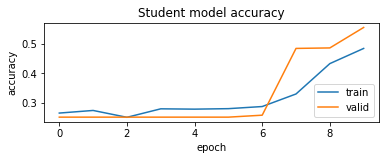

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(distiller_hist.history['acc'])  
plt.plot(distiller_hist.history['val_acc'])  
plt.title('Student model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'], loc='lower right')  


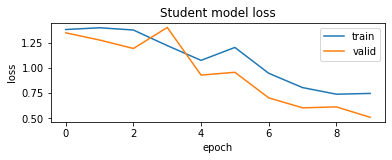

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(2)  

 # summarize history for loss  
plt.subplot(212)  
plt.plot(distiller_hist.history['student_loss'])  
plt.plot(distiller_hist.history['val_student_loss'])  
plt.title('Student model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'], loc='upper right')  
plt.show()
plt.tight_layout()